<a href="https://colab.research.google.com/github/CD-AC/Master_AI/blob/main/dinov2_image_retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Roboflow Notebooks banner](https://camo.githubusercontent.com/aec53c2b5fb6ed43d202a0ab622b58ba68a89d654fbe3abab0c0cc8bd1ff424e/68747470733a2f2f696b2e696d6167656b69742e696f2f726f626f666c6f772f6e6f7465626f6f6b732f74656d706c6174652f62616e6e657274657374322d322e706e673f696b2d73646b2d76657273696f6e3d6a6176617363726970742d312e342e33267570646174656441743d31363732393332373130313934)

# Image Retrieval with DINOv2

DINOv2, released by Meta Research in April 2023, implements a self-supervised method of training computer vision models.

DINOv2 was trained using 140 million images without labels. The embeddings generated by DINOv2 can be used for classification, image retrieval, segmentation, and depth estimation. With that said, Meta Research did not release heads for segmentation and depth estimation.

In this guide, we're going to talk through how to build an image-to-image retrieval system with DINOv2. We will:

1. Load a folder of images
2. Compute embeddings for each image
3. Save all the embeddings in a `faiss` index
4. Build the logic to search the index for an image

By the end of this notebook, we'll have a system that we can feed an image to return related images.

Without further ado, let's begin!

## Load Images

In this demo, we're going to build an image search engine for the [COCO 128 dataset](https://universe.roboflow.com/team-roboflow/coco-128) available on Roboflow Universe. First, let's download the dataset from Roboflow and make a list of all the files in the `train` folder on which we'll build our search engine.

To download this dataset, you will need a [free Roboflow account](https://app.roboflow.com).

_Note: You can provide any folder of images you want!_

In [ ]:
!pip install roboflow torch torchvision tqdm faiss-cpu numpy --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.

In [ ]:
import os
import torch
import roboflow
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import faiss
from torchvision import transforms

In [ ]:
ROBOFLOW_API_KEY = "AtupMVxLSrNwpTlcMng1"

# Inicializa la API de Roboflow
rf = roboflow.Roboflow(api_key=ROBOFLOW_API_KEY)

project = rf.workspace("team-roboflow").project("coco-128")
dataset = project.version(1).download("coco")

# Define las rutas a las imágenes
image_dir = os.path.join(dataset.location, "train")
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
print(f"Dataset downloaded to: {dataset.location}")
print(f"Found {len(image_files)} images.")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to COCO-128-1 in coco:: 100%|██████████| 386/386 [00:00<00:00, 7426.07it/s]

Dataset downloaded to: /content/COCO-128-1
Found 128 images.


In [ ]:
model = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print(f"Model loaded on device: {device}")

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
xFormers is not available (SwiGLU)
xFormers is not available (Attention)
xFormers is not available (Block)
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:00<00:00, 99.5MB/s]


Model loaded on device: cuda


In [ ]:
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])
    return transform(image)

def create_index(embeddings):
    d = 384
    index = faiss.IndexFlatL2(d)
    return index

def search_index(query_embedding, index, k=5):
    D, I = index.search(np.array([query_embedding]), k)
    return I[0]

In [ ]:
all_embeddings = []
for image_path in tqdm(image_files, desc="Generating Embeddings"):
    image_tensor = load_image(image_path)
    with torch.no_grad():
        embedding = model(image_tensor.unsqueeze(0).to(device))
    all_embeddings.append(embedding.cpu().numpy().flatten())

all_embeddings = np.array(all_embeddings).astype('float32')

print("\nCreating FAISS index...")
index = create_index(all_embeddings)
index.add(all_embeddings)
print(f"FAISS index created with {index.ntotal} vectors.")

Generating Embeddings:   0%|          | 0/128 [00:00<?, ?it/s]


Creating FAISS index...
FAISS index created with 128 vectors.


In [ ]:
query_image_path = np.random.choice(image_files)
query_image_tensor = load_image(query_image_path)
with torch.no_grad():
    query_embedding = model(query_image_tensor.unsqueeze(0).to(device)).cpu().numpy().flatten()

result_indices = search_index(query_embedding, index, k=6)

Query Image: 000000000149_jpg.rf.f7912cc38b39889e0b6472ba56c568fc.jpg


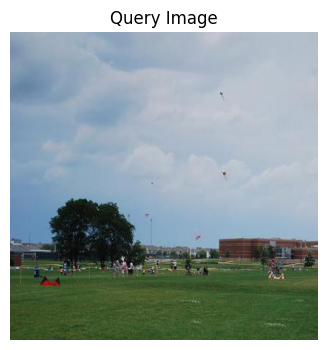

Search Results:


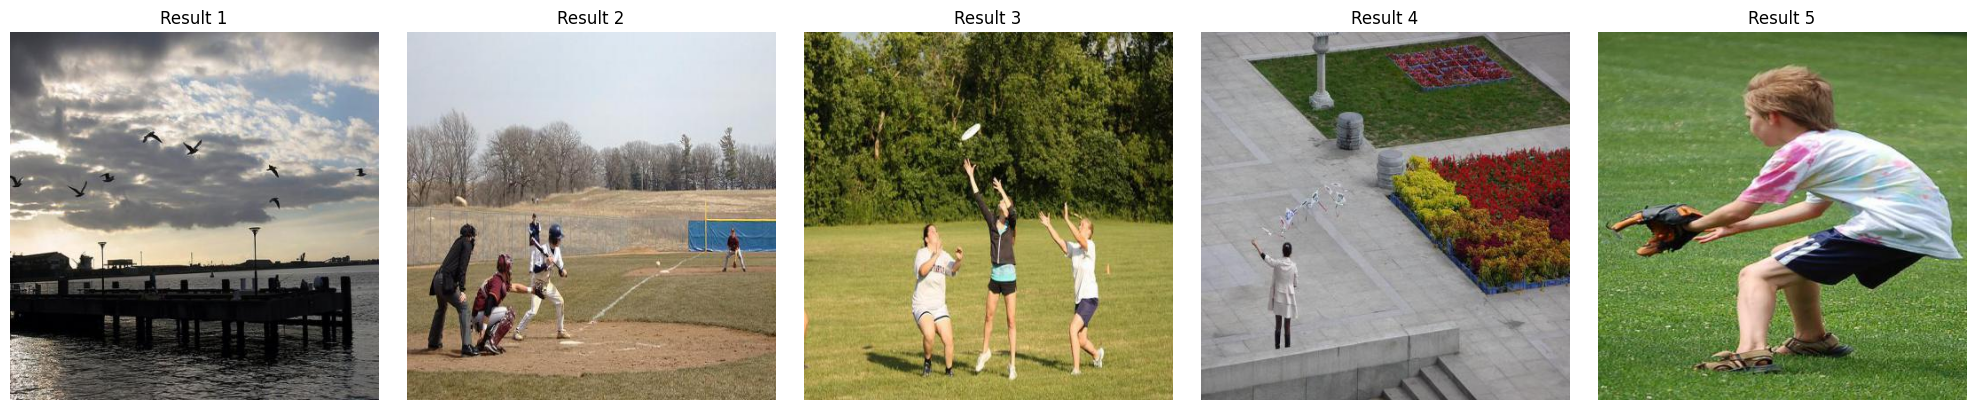

In [ ]:
import matplotlib.pyplot as plt

print(f"Query Image: {os.path.basename(query_image_path)}")
query_img_display = Image.open(query_image_path)
plt.figure(figsize=(4, 4))
plt.imshow(query_img_display)
plt.axis('off')
plt.title("Query Image")
plt.show()

print("Search Results:")
plt.figure(figsize=(20, 4))
num_results_to_show = 0
for i, idx in enumerate(result_indices):
    if image_files[idx] == query_image_path:
        continue
    if num_results_to_show >= 5:
        break
    num_results_to_show += 1
    result_image_path = image_files[idx]
    result_img_display = Image.open(result_image_path)
    ax = plt.subplot(1, 5, num_results_to_show)
    ax.imshow(result_img_display)
    ax.set_title(f"Result {num_results_to_show}")
    ax.axis('off')
plt.tight_layout()
plt.show()

#RESPUESTAS A LISTA DE PREGUNTAS

1. ¿Cuál es el propósito de las funciones workspace() y project() en rf.workspace("team-roboflow").project("coco-128")?

- *Respuesta : La workspace()función selecciona un espacio de trabajo específico en la plataforma Roboflow; en este caso, [Nombre del proyecto] "team-roboflow". project()A continuación, selecciona un proyecto de visión artificial específico dentro de ese espacio de trabajo; en este caso, [Nombre del proyecto] "coco-128". Esto permite que el código dirija con precisión el conjunto de datos deseado para su descarga.*

2. ¿Cuál es la finalidad de la llamada a la función load() en torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")?

- *Respuesta : El propósito de esta llamada de función es descargar y cargar un modelo previamente entrenado desde el repositorio de PyTorch HubObtiene específicamente la dinov2_vits14versión del modelo DINOv2 del facebookresearch/dinov2repositorio oficial, dejándolo listo para su uso en el script.*

3. ¿Cuál es el valor de device si no hay disponibles GPUs en la infraestructura de computación que ejecuta el notebook?

- *Respuesta : Si no hay ninguna GPU disponible, el valor de la devicevariable será la cadena 'cpu'. El código device = "cuda" if torch.cuda.is_available() else "cpu"comprueba explícitamente la disponibilidad de la GPU con CUDA habilitado y recurre a la CPU si no la encuentra.*

4. ¿Por qué son necesarias las transformaciones aplicadas a cada imagen en la función load_image()?

- *Respuesta : Estas transformaciones son necesarias porque los modelos de aprendizaje profundo como DINOv2 se entrenan con imágenes de un formato muy específico. Las transformaciones (como el redimensionamiento, el recorte central y la normalización de los valores de los píxeles) garantizan que cualquier nueva imagen de entrada tenga el mismo formato que las imágenes con las que se entrenó originalmente el modelo. Esta consistencia es crucial para que el modelo genere incrustaciones precisas y significativas.*

5. ¿Qué información almacena la variable all_embeddings? ¿En qué ubicación se almacena? ¿Para qué se utiliza en el notebook después de haber sido almacenada?

- *Respuesta : La all_embeddingsvariable almacena el conjunto completo de representaciones vectoriales numéricas (incrustaciones) para cada imagen en el conjunto de datos.Se almacena en la RAM del ordenador como una lista de Python que luego se convierte en una matriz de NumPy. Una vez completada, se utiliza para crear el índice FAISS, que organiza estos vectores para una búsqueda eficiente..*

6. La función search_index() permite localizar embeddings en el índice creado en FAISS. ¿Cuál es el contenido de I[0] en esta función? ¿Cuántos elementos tendrá esta variable?

- *Respuesta : La variable I[0]contiene los índices de las incrustaciones más similares en el índice FAISS en relación con la incrustación de la consulta. Estos índices corresponden a las posiciones de las imágenes similares en la image_fileslista original. El número de elementos en I[0]será igual al valor de kpasado a la función de búsqueda, que representa el número de vecinos más cercanos a recuperar.*

7. ¿Qué llamada en el código fuente es la que recupera el embedding asociado a una imagen (search_file) en DINOV2?

- *Respuesta : La llamada específica que pasa una imagen a través del modelo DINOv2 para obtener su incrustación es model(image.to(device)). Esta línea toma el tensor de imagen preprocesado, lo envía al dispositivo activo (GPU o CPU) y lo alimenta para modelcalcular la representación vectorial resultante.*

8. El modelo DINOV2 tiene varias versiones. ¿En qué se diferencia la versión dinov2_vits14 del resto de versiones?

- *Respuesta : El nombre dinov2_vits14describe la arquitectura del modelo. "ViT" significa Transformador de Visión, "s" significa "pequeño" y "14" se refiere al tamaño del parche de entrada (14x14 píxeles). Esta versión es una variante más pequeña y computacionalmente más económica del modelo DINOv2, lo que la hace más rápida y requiere menos memoria en comparación con versiones más grandes como dinov2_vitb14(Base) o dinov2_vitl14(Grande), a costa de cierta precisión.*

9. En la función create_index() se crea el índice FAISS utilizado para el buscador. ¿Por qué se inicializa el índice con el valor 384 en faiss.IndexFlatL2(384)?

- *Respuesta : El índice se inicializa con el valor 384porque esa es la dimensionalidad (es decir, la longitud del vector) de las incrustaciones producidas por el dinov2_vits14modelo. El índice FAISS debe conocer el tamaño de los vectores que almacenará y buscará para funcionar correctamente.*

10. ¿A través de qué llamada se descarga el contenido del dataset de Roboflow para que esté disponible en el notebook?

- *Respuesta : El contenido del conjunto de datos de Roboflow se descarga y se pone a disposición mediante la llamada a la función project.version(1).download("coco"). Este método indica a la biblioteca de Roboflow que descargue la versión 1 del proyecto seleccionado y utilice el formato "coco" para su estructura de directorios.*